In [22]:
ssc.stop(stopSparkContext=False)

-------------------------------------------
Time: 2020-12-09 22:46:51
-------------------------------------------
{'geohash': '9qd', 'mean': 52.493380242360395, 'M2': 2006319.0985338576}
{'geohash': '9qf', 'mean': 75.3640716152061, 'M2': 1505761.8041939298}
{'geohash': '9q9', 'mean': 48.39858237632797, 'M2': 2036425.6323099965}
{'geohash': '9qb', 'mean': 111.466648506333, 'M2': 1131647.5225550227}
{'geohash': '9qc', 'mean': 69.64653347655315, 'M2': 1737245.7663848791}



In [38]:
import pyspark.sql.functions as F
from  pyspark.sql.functions import udf
from pyspark.sql import DataFrame
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
from pyspark.streaming import StreamingContext
# The "1" here is the number of seconds between microbatches:
ssc = StreamingContext(sc, 1)

# Required to be able to do state updates:
ssc.checkpoint("checkpoint")

In [40]:
# Assumes the stream is running on the same machine as the driver.
# That's not very common, so you'll probably change 'localhost'
# to something else.
sock = ssc.socketTextStream("orion03", 37600)

In [41]:
__base32 = '0123456789bcdefghjkmnpqrstuvwxyz'
def encode(latitude, longitude, precision=12):
    """
    Encode a position given in float arguments latitude, longitude to
    a geohash which will have the character count precision.
    """
    lat_interval = (-90.0, 90.0)
    lon_interval = (-180.0, 180.0)
    geohash = []
    bits = [16, 8, 4, 2, 1]
    bit = 0
    ch = 0
    even = True
    while len(geohash) < precision:
        if even:
            mid = (lon_interval[0] + lon_interval[1]) / 2
            if longitude > mid:
                ch |= bits[bit]
                lon_interval = (mid, lon_interval[1])
            else:
                lon_interval = (lon_interval[0], mid)
        else:
            mid = (lat_interval[0] + lat_interval[1]) / 2
            if latitude > mid:
                ch |= bits[bit]
                lat_interval = (mid, lat_interval[1])
            else:
                lat_interval = (lat_interval[0], mid)
        even = not even
        if bit < 4:
            bit += 1
        else:
            geohash += __base32[ch]
            bit = 0
            ch = 0
    return ''.join(geohash)

def getLatLong(words):
    words.append(encode(float(words[1]),float(words[2]),3))
    return words

In [42]:
features = {'temperature': 10,
                   'pressure': 6,
                   'humidity': 8,
                   'precipitation': 13,
                   'visibility': 15,
                   'wind speed': 17}
geo_hashes = ['9qb', '9qc', '9qf', '9q9' , '9qd']

In [43]:
def getReqdFields(words):
    '''
    geohash - 18, surface temperature 10, pressure 6, humidity 8, precipitation 13, visibility 15, wind speed 17
    '''
#     fields = [float(words[10]),float(words[6]),float(words[8]),float(words[13]),float(words[15]),float(words[17]), words[18]]
    fields = [(1,float(words[10]),0),float(words[6]),float(words[8]),float(words[13]),float(words[15]),float(words[17])]
    fields = [(1,float(words[10]),0),(1,float(words[6]),0),(1,float(words[8]),0),(1,float(words[13]),0),(1,float(words[15]),0),(1,float(words[17]),0)]
    dict = {
        "temperature" :float(words[10]),
        'pressure': float(words[6]),
        'humidity': float(words[8]),
        'precipitation': float(words[13]),
        'visibility': float(words[15]),
        'wind speed': float(words[17])
    }
#     fields = [words[10],words[18]]
    return (words[18],fields)
#     return (words[18],dict)

In [44]:
def update(existingAggregate, newValue):
    (count1, mean1, M2_1) = existingAggregate
    (count2, mean2, M2_2) = newValue
    
    if mean1 == 'null':
        mean1 = 0.0
        
    if mean2 == 'null':
        mean2 = 0.0
        
    count1 = int(count1)
    count1 += int(count2)
    delta = mean2 - mean1
    mean1 += delta / count1
    delta2 = mean2 - mean1
    M2_1 += delta * delta2
    return (count1, mean1, M2_1)

In [45]:
def computeVal(new, old):
    newList = []
    if old is None:
        old = [(0,0,0),(0,0,0),(0,0,0),(0,0,0),(0,0,0),(0,0,0)]
    if new is None:
        new = [(0,0,0),(0,0,0),(0,0,0),(0,0,0),(0,0,0),(0,0,0)]
        
    for i in range(6):
        newAggr = update(old[i], new[i])
        newList.append(newAggr)

    return newList

In [46]:
def computeVal2(newValuesList, existAgg):
    if not existAgg:
        existAgg = [(0,0,0),(0,0,0),(0,0,0),(0,0,0),(0,0,0),(0,0,0)]

    for newValues in newValuesList:
        for i in range(6):
            existAgg[i] = update(existAgg[i], newValues[i])
            
    return existAgg
    

In [47]:
def plot_distribution(rdd):
    df = pd.DataFrame(rdd.collect(), columns=['geohash','temperature'])
    df.sort_values('geohash', ascending=True).plot(kind='bar', x='geohash', color='red')

In [48]:
def plot_distribution2(rdd):
    df = pd.DataFrame(rdd.collect(), columns=['geohash','pressure'])
    df.sort_values('geohash', ascending=True).plot(kind='bar', x='geohash', color='blue')

In [49]:
def plot_distribution3(rdd):
    df = pd.DataFrame(rdd.collect(), columns=['geohash','humidity'])
    df.sort_values('geohash', ascending=True).plot(kind='bar', x='geohash', color='green')

In [50]:
def plot_distribution4(rdd):
    df = pd.DataFrame(rdd.collect(), columns=['geohash','precipitation'])
    df.sort_values('geohash', ascending=True).plot(kind='bar', x='geohash', color='cyan')

In [51]:
def plot_distribution5(rdd):
    df = pd.DataFrame(rdd.collect(), columns=['geohash','visibility'])
    df.sort_values('geohash', ascending=True).plot(kind='bar', x='geohash', color='orange')

In [52]:
def plot_distribution6(rdd):
    df = pd.DataFrame(rdd.collect(), columns=['geohash','wind speed'])
    df.sort_values('geohash', ascending=True).plot(kind='bar', x='geohash', color='teal')

In [53]:
words = sock.map(lambda line: line.split("	"))
words_with_geohash = words.map(lambda wordz: getLatLong(wordz))
filtered_data= words_with_geohash.filter(lambda x: x[18] in geo_hashes)
weather_data = filtered_data.map(lambda x: getReqdFields(x))
reduced = weather_data.reduceByKey(lambda x, y: computeVal(y, x))
distrib = reduced.updateStateByKey(computeVal2)

distrib_geo = distrib.map(lambda rdd: {'geohash':rdd[0],
                                       'temperature':rdd[1][0][1],
                                       'M2':rdd[1][0][2]
                                      })

distrib_geo2 = distrib.map(lambda rdd: {'geohash':rdd[0],
                                       'pressure':rdd[1][1][1],
                                       'M2':rdd[1][1][2]
                                      })

distrib_geo3 = distrib.map(lambda rdd: {'geohash':rdd[0],
                                       'humidity':rdd[1][2][1],
                                       'M2':rdd[1][2][2]
                                      })

distrib_geo4 = distrib.map(lambda rdd: {'geohash':rdd[0],
                                       'precipitation':rdd[1][3][1],
                                       'M2':rdd[1][3][2]
                                      })

distrib_geo5 = distrib.map(lambda rdd: {'geohash':rdd[0],
                                       'visibility':rdd[1][4][1],
                                       'M2':rdd[1][4][2]
                                      })

distrib_geo6 = distrib.map(lambda rdd: {'geohash':rdd[0],
                                       'wind speed':rdd[1][5][1],
                                       'M2':rdd[1][5][2]
                                      })


distrib_geo.foreachRDD(plot_distribution)
distrib_geo2.foreachRDD(plot_distribution2)
distrib_geo3.foreachRDD(plot_distribution3)
distrib_geo4.foreachRDD(plot_distribution4)
distrib_geo5.foreachRDD(plot_distribution5)
distrib_geo6.foreachRDD(plot_distribution6)

# distrib.foreachRDD(plot_distribution)

# reduced = weather_data_mapped.reduceByKey(lambda x, y: y)
# words_with_geohash.foreachRDD(printRDD)

# Print out the distribution for good measure
# reduced.pprint()
distrib_geo.pprint()
# weather_data.pprint()
# filtered_data.pprint()
# wordsTemp = words.map(lambda x: getLatLong(x))

# Running this will start listening:
ssc.start()

-------------------------------------------
Time: 2020-12-09 23:08:10
-------------------------------------------
{'geohash': '9qd', 'temperature': 94.22139555555556, 'M2': 53266.0282826188}
{'geohash': '9q9', 'temperature': 93.26694666666667, 'M2': 52192.34004313706}
{'geohash': '9qb', 'temperature': 277.77417, 'M2': 0.0}

-------------------------------------------
Time: 2020-12-09 23:08:11
-------------------------------------------
{'geohash': '9qd', 'temperature': 107.60127945767196, 'M2': 85847.90365122746}
{'geohash': '9qf', 'temperature': 15.995929740441708, 'M2': 69596.57696703213}
{'geohash': '9q9', 'temperature': 104.92814299903847, 'M2': 84828.38001964623}
{'geohash': '9qb', 'temperature': 278.1117893055556, 'M2': 15.046257003863454}
{'geohash': '9qc', 'temperature': 25.399975841081275, 'M2': 70967.46500002636}

-------------------------------------------
Time: 2020-12-09 23:08:12
-------------------------------------------
{'geohash': '9qd', 'temperature': 112.740213182226

/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained unt

-------------------------------------------
Time: 2020-12-09 23:08:13
-------------------------------------------
{'geohash': '9qd', 'temperature': 116.06753815106408, 'M2': 151209.7344387272}
{'geohash': '9qf', 'temperature': 28.206671954892474, 'M2': 210164.39890164082}
{'geohash': '9q9', 'temperature': 113.42552343372759, 'M2': 154638.0374989286}
{'geohash': '9qb', 'temperature': 278.65191532626574, 'M2': 293.03630220342677}
{'geohash': '9qc', 'temperature': 39.387491827325505, 'M2': 212029.68927409485}



/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained unt

-------------------------------------------
Time: 2020-12-09 23:08:14
-------------------------------------------
{'geohash': '9qd', 'temperature': 118.43313012677477, 'M2': 182267.6753840117}
{'geohash': '9qf', 'temperature': 31.81379605549517, 'M2': 276678.39084642555}
{'geohash': '9q9', 'temperature': 115.88609254907732, 'M2': 190068.38847243713}
{'geohash': '9qb', 'temperature': 278.84260143676306, 'M2': 517.0939718463768}
{'geohash': '9qc', 'temperature': 42.879346436386996, 'M2': 274360.5537726269}



/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained unt

-------------------------------------------
Time: 2020-12-09 23:08:15
-------------------------------------------
{'geohash': '9qd', 'temperature': 120.24230240967368, 'M2': 214671.4084411876}
{'geohash': '9qf', 'temperature': 34.60067459047054, 'M2': 346034.9501269741}
{'geohash': '9q9', 'temperature': 117.69404607913792, 'M2': 222428.478544337}
{'geohash': '9qb', 'temperature': 278.90440539742855, 'M2': 558.8054185754326}
{'geohash': '9qc', 'temperature': 45.301891943178745, 'M2': 333634.69377064373}



/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained unt

-------------------------------------------
Time: 2020-12-09 23:08:16
-------------------------------------------
{'geohash': '9qd', 'temperature': 120.24230240967368, 'M2': 214671.4084411876}
{'geohash': '9qf', 'temperature': 34.60067459047054, 'M2': 346034.9501269741}
{'geohash': '9q9', 'temperature': 117.69404607913792, 'M2': 222428.478544337}
{'geohash': '9qb', 'temperature': 278.90440539742855, 'M2': 558.8054185754326}
{'geohash': '9qc', 'temperature': 45.301891943178745, 'M2': 333634.69377064373}



/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained unt

-------------------------------------------
Time: 2020-12-09 23:08:17
-------------------------------------------
{'geohash': '9qd', 'temperature': 121.8047801085878, 'M2': 239328.9076931877}
{'geohash': '9qf', 'temperature': 36.97052376131608, 'M2': 399422.40561682364}
{'geohash': '9q9', 'temperature': 119.21872427254435, 'M2': 246851.18413711313}
{'geohash': '9qb', 'temperature': 278.9579727993396, 'M2': 590.7425812491092}
{'geohash': '9qc', 'temperature': 47.482891956545615, 'M2': 384589.1182272207}



/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained unt

-------------------------------------------
Time: 2020-12-09 23:08:18
-------------------------------------------
{'geohash': '9qd', 'temperature': 122.9728795820448, 'M2': 262565.59984272305}
{'geohash': '9qf', 'temperature': 38.760344632631146, 'M2': 453144.40887771815}
{'geohash': '9q9', 'temperature': 120.42272154860598, 'M2': 271538.03291332105}
{'geohash': '9qb', 'temperature': 278.9867097474959, 'M2': 604.3783921195054}
{'geohash': '9qc', 'temperature': 49.261095825507084, 'M2': 436800.21082844323}



/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained unt

-------------------------------------------
Time: 2020-12-09 23:08:19
-------------------------------------------
{'geohash': '9qd', 'temperature': 123.96107099224893, 'M2': 286177.90816692944}
{'geohash': '9qf', 'temperature': 40.165300457440765, 'M2': 505267.2352421313}
{'geohash': '9q9', 'temperature': 121.41186754858983, 'M2': 296428.7784615075}
{'geohash': '9qb', 'temperature': 279.0127453228151, 'M2': 621.1931685451417}
{'geohash': '9qc', 'temperature': 50.76222910770205, 'M2': 489205.307528966}



/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained unt

-------------------------------------------
Time: 2020-12-09 23:08:20
-------------------------------------------
{'geohash': '9qd', 'temperature': 124.81343294120641, 'M2': 308300.4693292612}
{'geohash': '9qf', 'temperature': 41.410884901618125, 'M2': 556940.8483580785}
{'geohash': '9q9', 'temperature': 122.30617383318538, 'M2': 321343.6412392496}
{'geohash': '9qb', 'temperature': 279.0300418979828, 'M2': 630.5129595035858}
{'geohash': '9qc', 'temperature': 52.090146428083074, 'M2': 540466.3109209194}



/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained unt

-------------------------------------------
Time: 2020-12-09 23:08:21
-------------------------------------------
{'geohash': '9qd', 'temperature': 125.63781967726933, 'M2': 332705.38977658097}
{'geohash': '9qf', 'temperature': 42.57979499071222, 'M2': 613524.1675380144}
{'geohash': '9q9', 'temperature': 123.2109931434373, 'M2': 351681.31374194106}
{'geohash': '9qb', 'temperature': 279.09446108420644, 'M2': 787.5010871806294}
{'geohash': '9qc', 'temperature': 53.40824462975086, 'M2': 602198.9990307498}



/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained unt

-------------------------------------------
Time: 2020-12-09 23:08:22
-------------------------------------------
{'geohash': '9qd', 'temperature': 126.56288802764232, 'M2': 365078.46723834216}
{'geohash': '9qf', 'temperature': 43.84808307328158, 'M2': 681453.4308461768}
{'geohash': '9q9', 'temperature': 124.09691185460932, 'M2': 382606.05078037066}
{'geohash': '9qb', 'temperature': 279.16277461115067, 'M2': 975.1039533158333}
{'geohash': '9qc', 'temperature': 54.71517469244313, 'M2': 664837.2023052799}



/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained unt

-------------------------------------------
Time: 2020-12-09 23:08:23
-------------------------------------------
{'geohash': '9qd', 'temperature': 126.56288802764232, 'M2': 365078.46723834216}
{'geohash': '9qf', 'temperature': 43.84808307328158, 'M2': 681453.4308461768}
{'geohash': '9q9', 'temperature': 124.09691185460932, 'M2': 382606.05078037066}
{'geohash': '9qb', 'temperature': 279.16277461115067, 'M2': 975.1039533158333}
{'geohash': '9qc', 'temperature': 54.71517469244313, 'M2': 664837.2023052799}



/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained unt

-------------------------------------------
Time: 2020-12-09 23:08:24
-------------------------------------------
{'geohash': '9qd', 'temperature': 127.30367822895339, 'M2': 390327.380568057}
{'geohash': '9qf', 'temperature': 44.887591476924754, 'M2': 736400.8079714738}
{'geohash': '9q9', 'temperature': 124.82789338895532, 'M2': 408585.37003320677}
{'geohash': '9qb', 'temperature': 279.18052366515957, 'M2': 990.9814107936976}
{'geohash': '9qc', 'temperature': 55.77964497938226, 'M2': 717458.2266033705}



/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained unt

-------------------------------------------
Time: 2020-12-09 23:08:25
-------------------------------------------
{'geohash': '9qd', 'temperature': 128.0127310619908, 'M2': 418925.1428116789}
{'geohash': '9qf', 'temperature': 45.88555543336041, 'M2': 799897.4522832991}
{'geohash': '9q9', 'temperature': 125.51171611743956, 'M2': 438635.15031195746}
{'geohash': '9qb', 'temperature': 279.2410119724387, 'M2': 1204.3720041803927}
{'geohash': '9qc', 'temperature': 56.78859624012311, 'M2': 778313.2292141622}



/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home2/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained unt

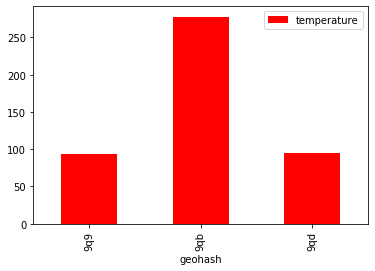

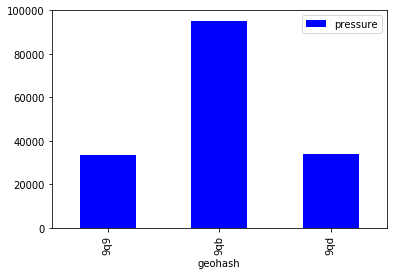

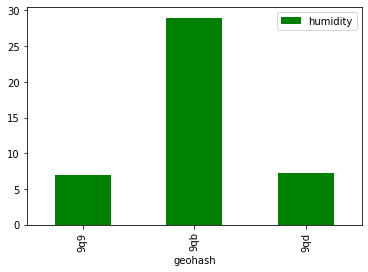

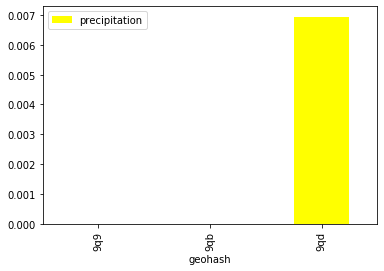

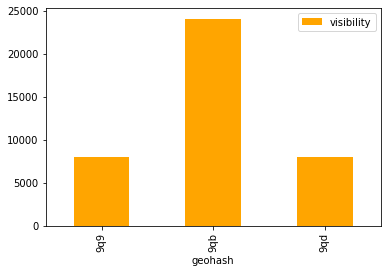

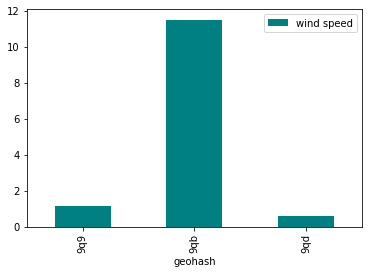

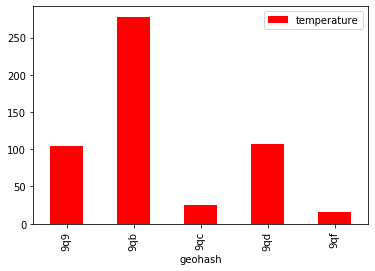

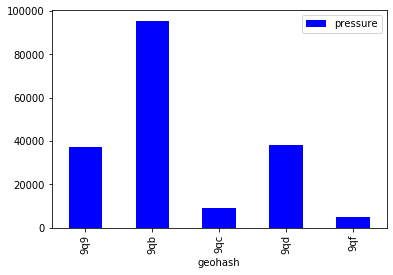

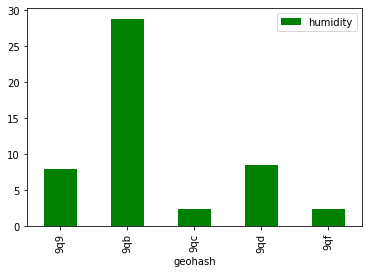

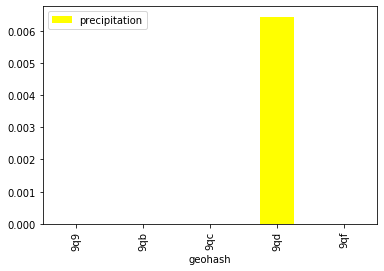

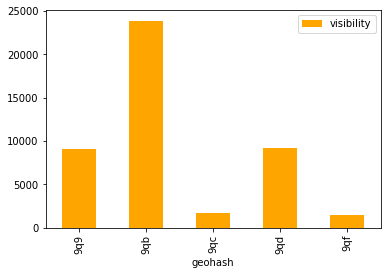

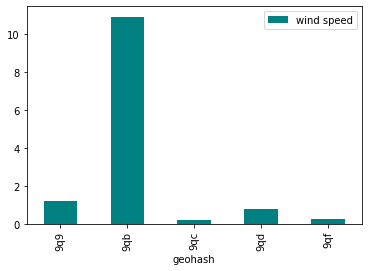

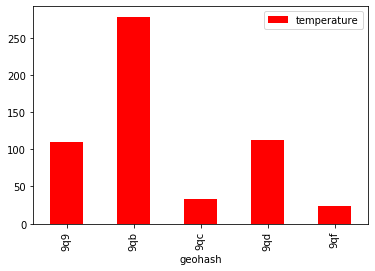

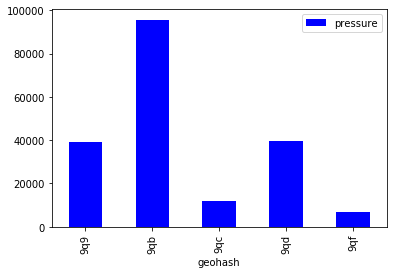

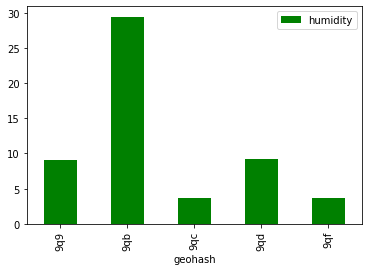

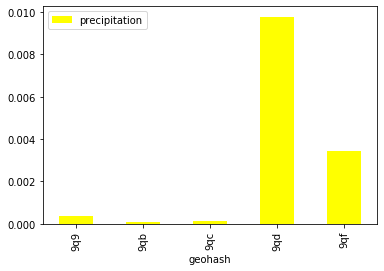

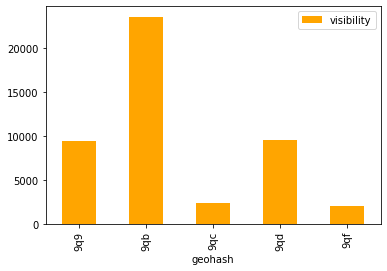

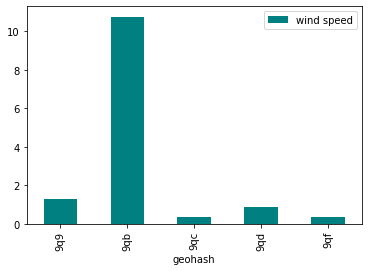

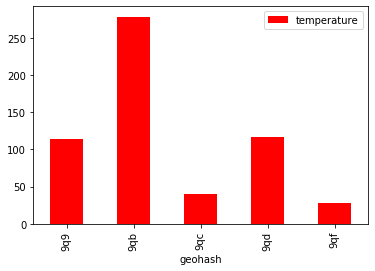

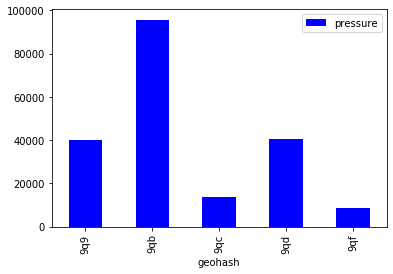

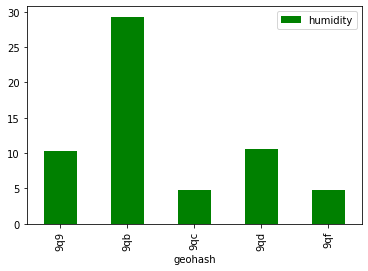

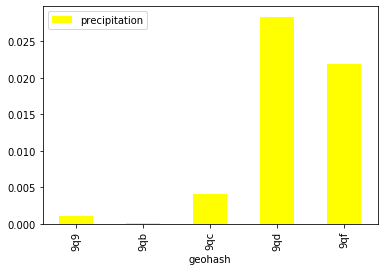

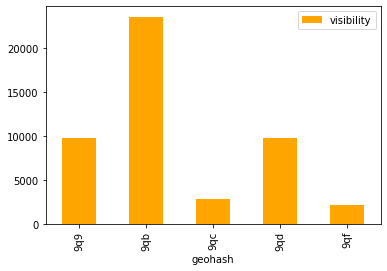

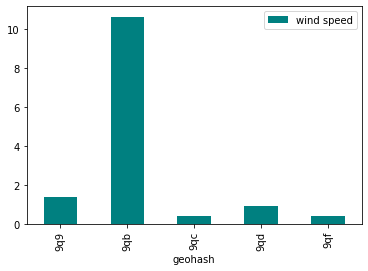

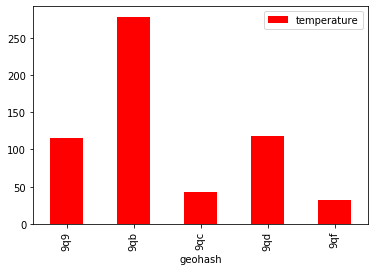

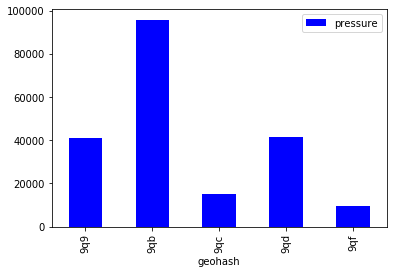

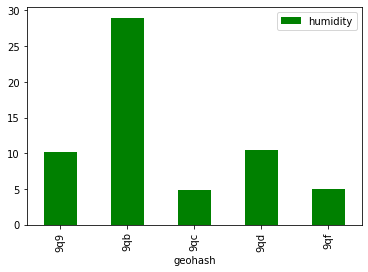

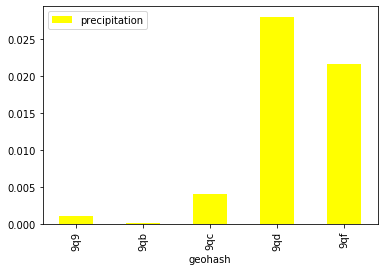

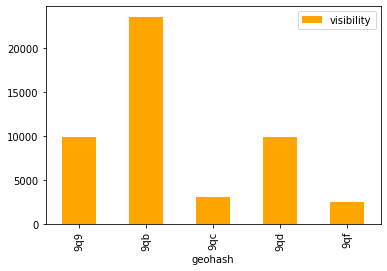

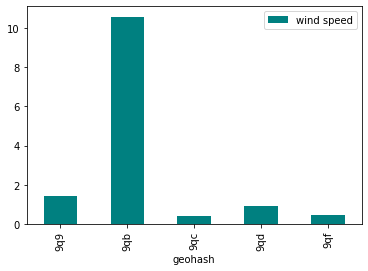

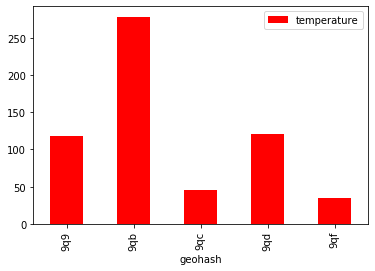

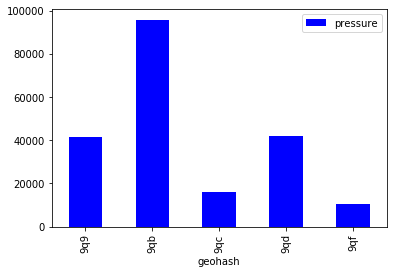

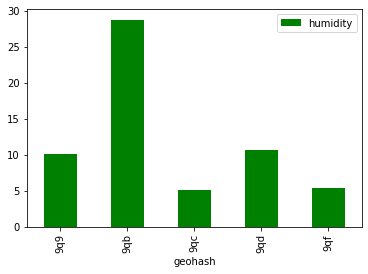

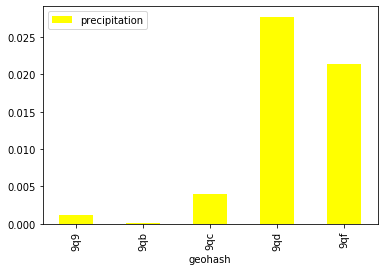

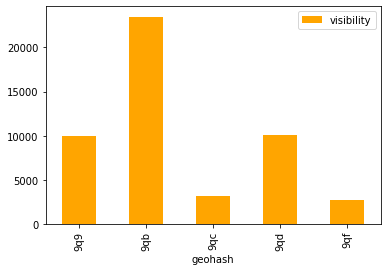

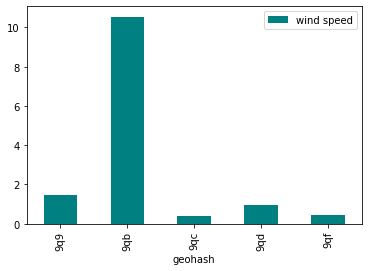

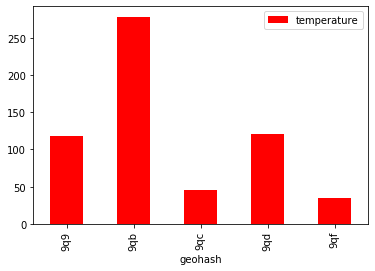

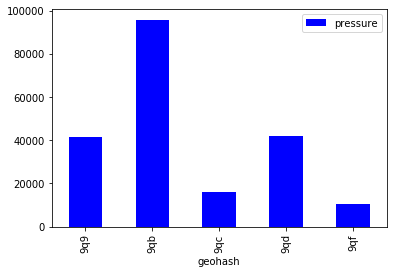

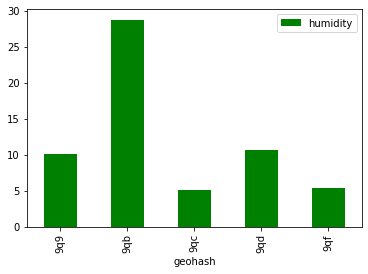

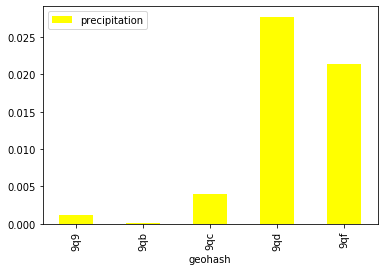

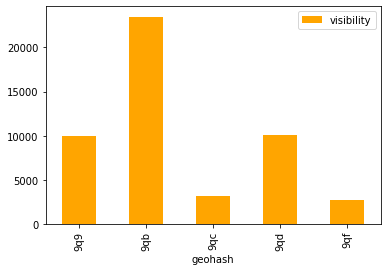

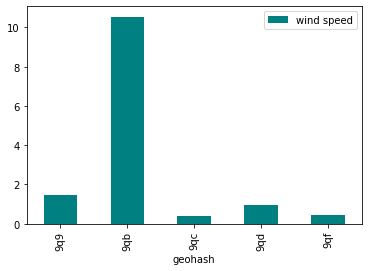

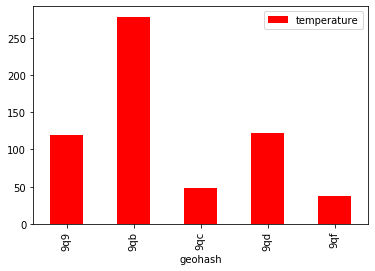

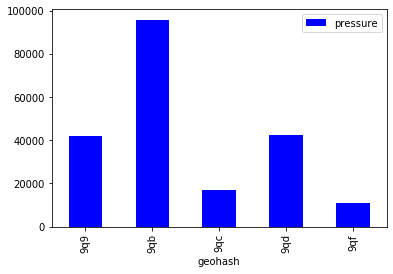

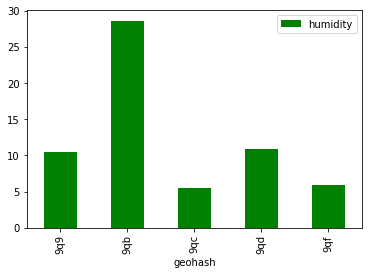

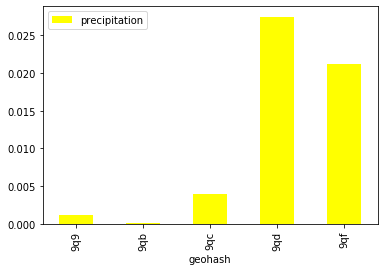

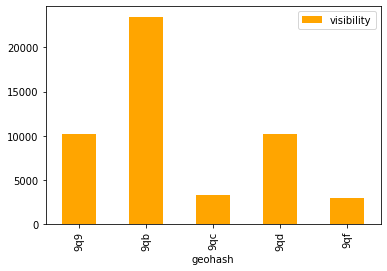

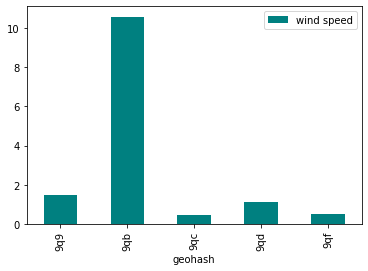

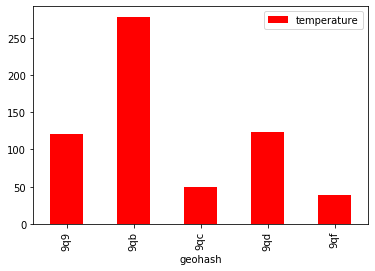

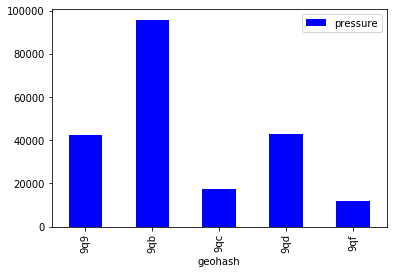

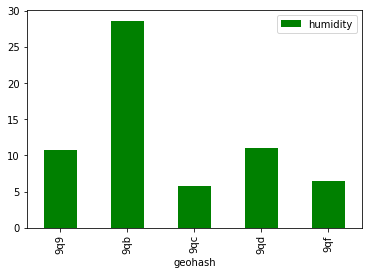

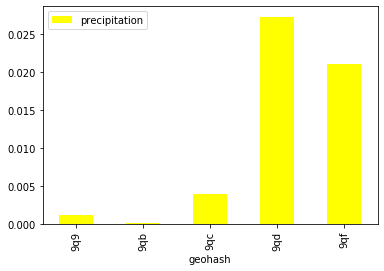

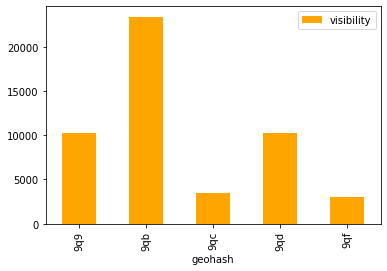

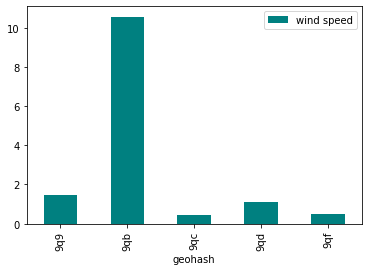

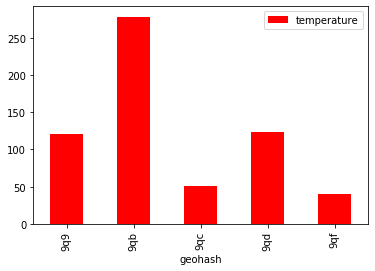

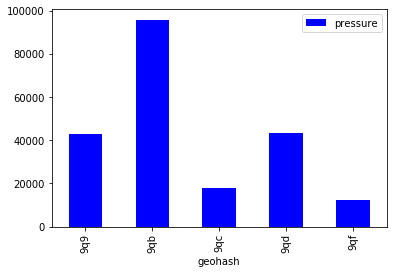

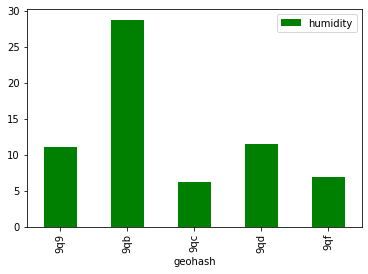

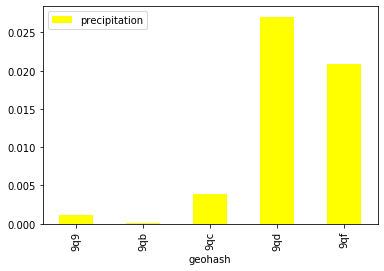

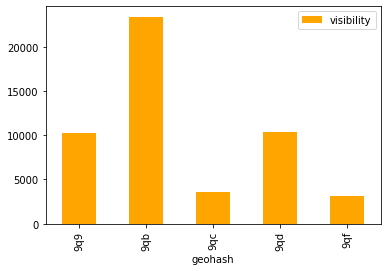

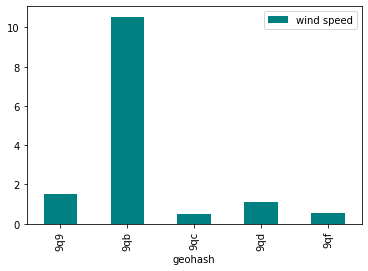

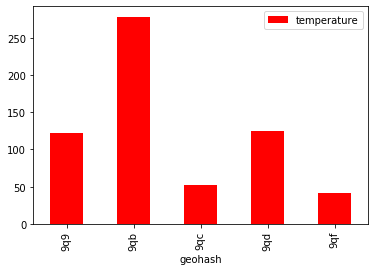

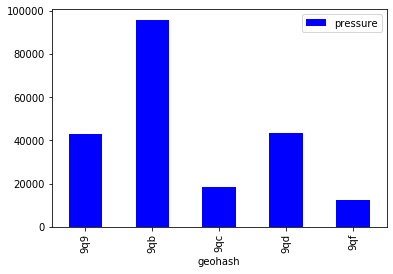

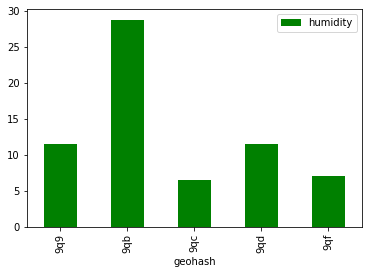

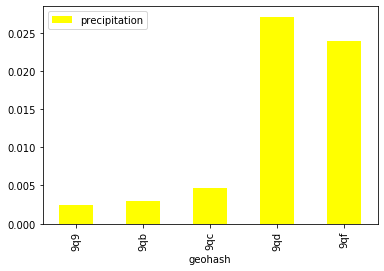

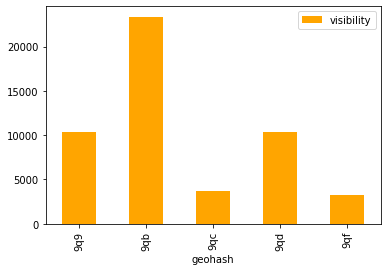

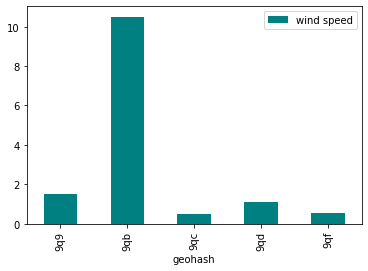

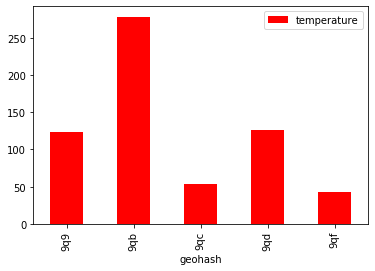

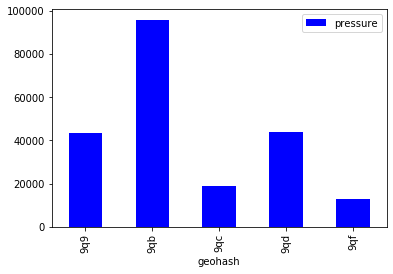

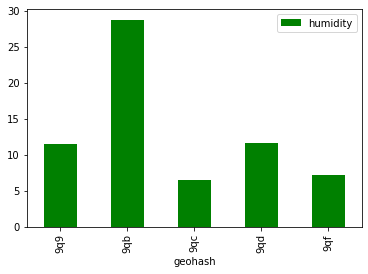

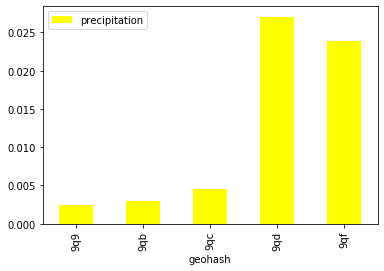

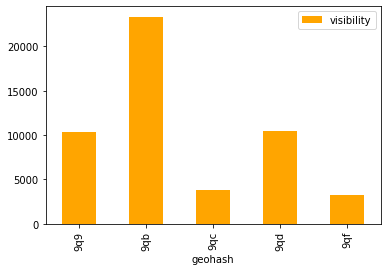

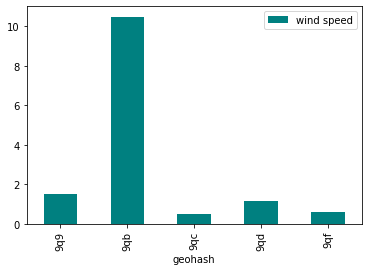

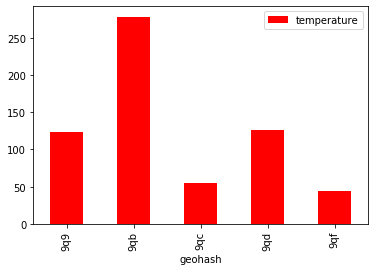

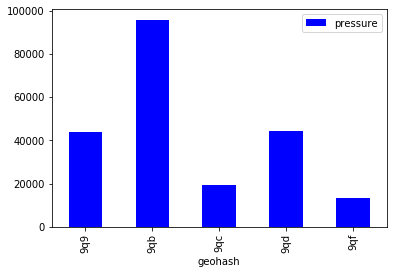

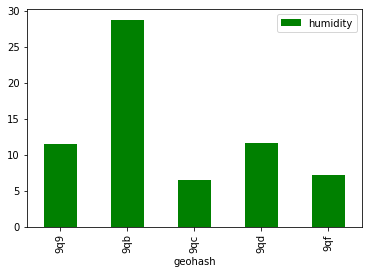

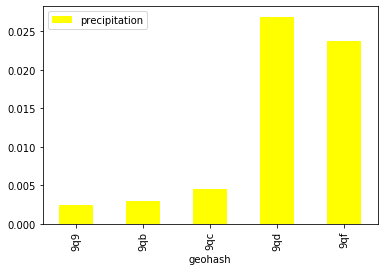

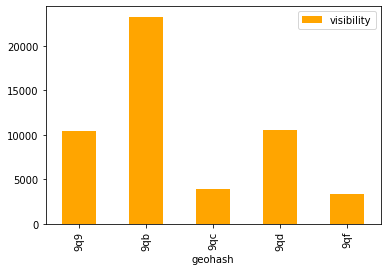

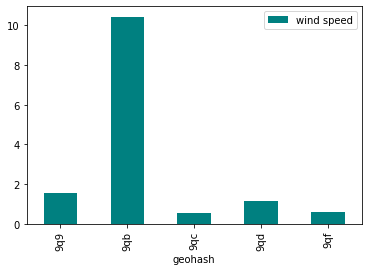

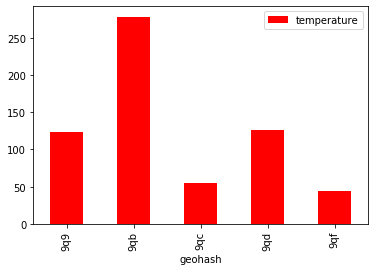

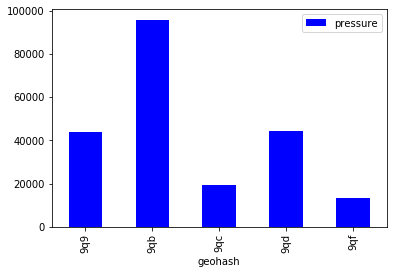

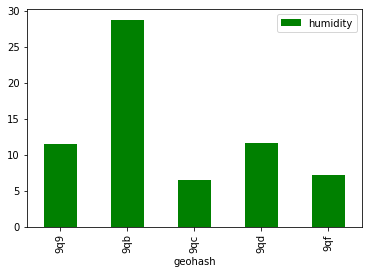

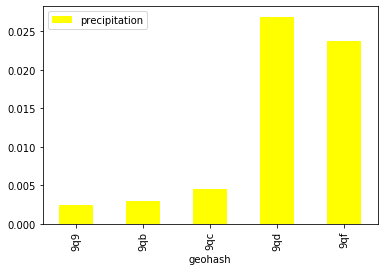

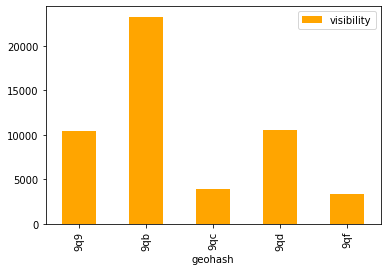

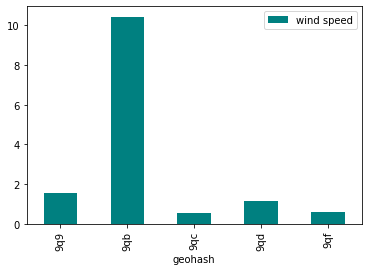

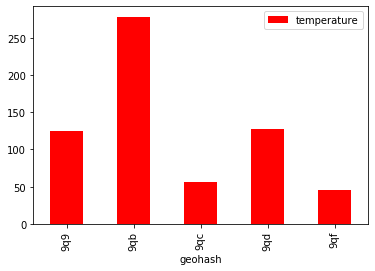

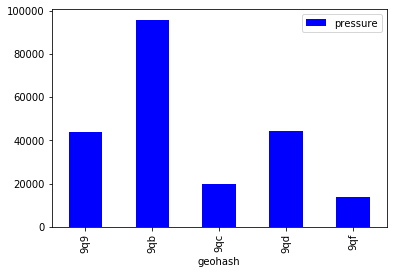

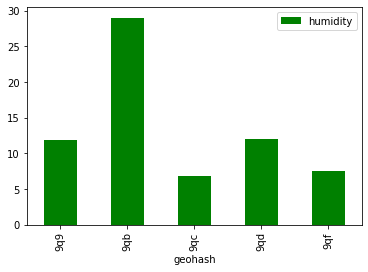

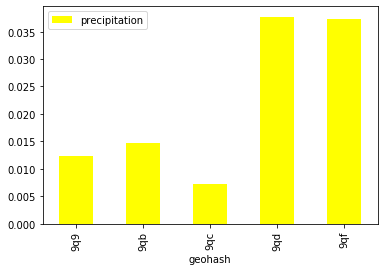

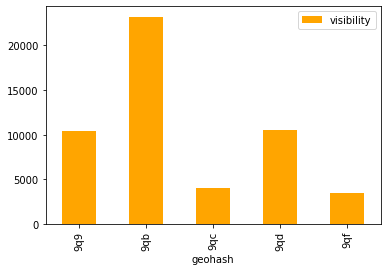

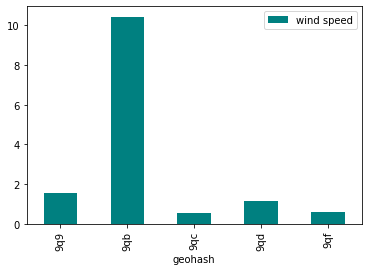

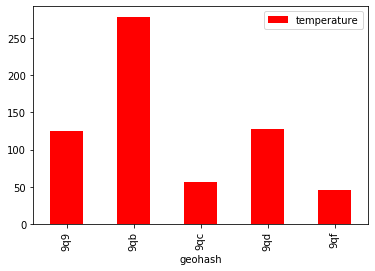

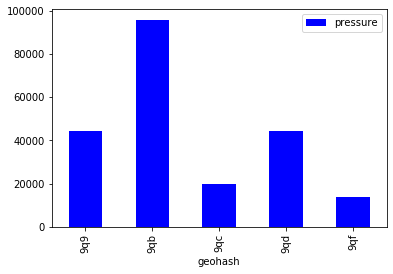

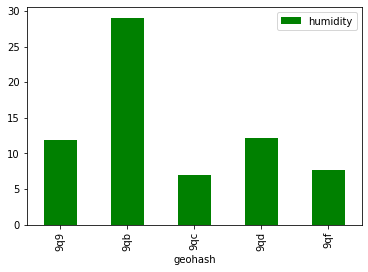

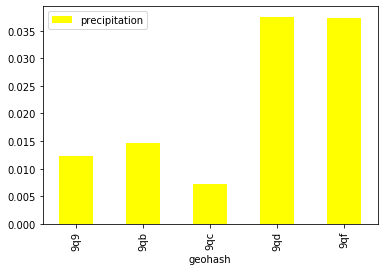

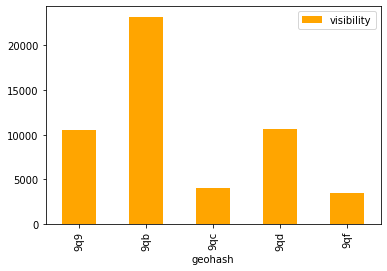

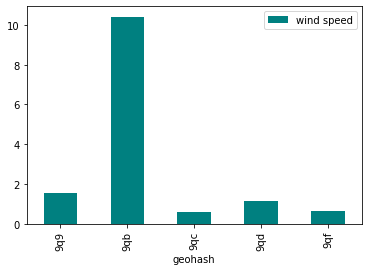

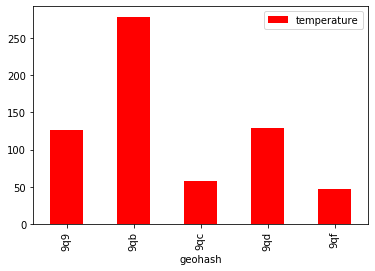

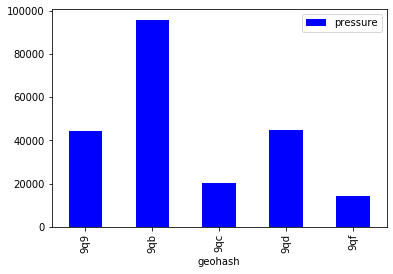

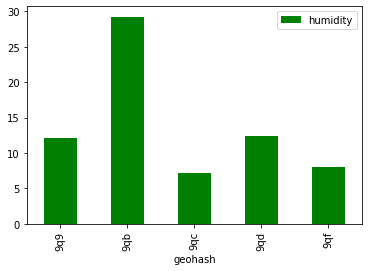

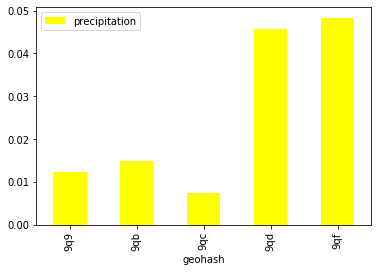

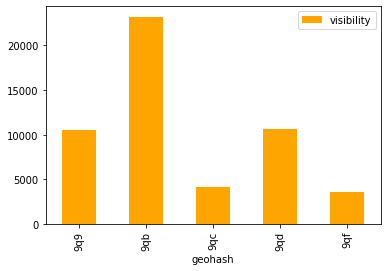

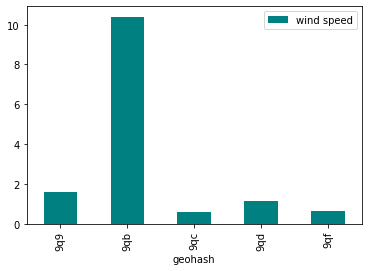

In [54]:
ssc.stop(stopSparkContext=False)